# Rasterio

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/giswqs/geog-312/blob/main/book/geospatial/rasterio.ipynb)

## Overview

[Rasterio](https://rasterio.readthedocs.io/) is a Python library that allows you to read, write, and analyze geospatial raster data. Built on top of [GDAL](https://gdal.org) (Geospatial Data Abstraction Library), it provides an efficient interface to work with raster datasets, such as satellite images, digital elevation models (DEMs), and other gridded data. Rasterio simplifies common geospatial tasks and helps to bridge the gap between raw geospatial data and analysis, especially when combined with other Python libraries like `numpy`, `pandas`, and `matplotlib`.

Raster data is essentially a grid of pixels (cells), where each pixel contains a value representing some geographic information such as elevation, temperature, or reflectance. Rasterio provides an easy way to handle these data types while preserving their georeferenced characteristics.

## Learning Objectives

By the end of this lecture, you should be able to:

- Read, write, and manipulate raster datasets using the Rasterio library.
- Extract metadata and perform operations on raster bands.
- Visualize raster datasets and overlay them with vector data.
- Perform geospatial operations such as clipping, reprojecting, and raster algebra.
- Apply Rasterio to practical geospatial analysis tasks, such as calculating indices and manipulating raster data for specific use cases.

## Installation

Before working with Rasterio, you need to install the library. You can do this by running the following command in your Python environment. Uncomment the line below if you're working in a Jupyter notebook or other interactive Python environment.

In [ ]:
# %pip install rasterio fiona

## Importing libraries

To get started, you'll need to import rasterio along with a few other useful Python libraries. These libraries will allow us to perform different types of geospatial operations, manipulate arrays, and visualize raster data.

In [1]:
import rasterio
import rasterio.plot
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

* `rasterio`: The main library for reading and writing raster data.
* `rasterio.plot`: A submodule of Rasterio for plotting raster data.
* `geopandas`: A popular library for handling vector geospatial data.
* `numpy`: A powerful library for array manipulations, which is very useful for raster data.
* `matplotlib`: A standard plotting library in Python for creating visualizations.

## Reading Raster Data

To read raster data, you can use the `rasterio.open()` function. This function creates a connection to the file without loading the entire dataset into memory. This is particularly useful for large datasets like satellite imagery or high-resolution DEMs, as they might be too big to fit into memory at once.

In this example, we are opening a DEM (digital elevation model) raster file from a URL:

In [2]:
raster_path = (
    "https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif"
)
src = rasterio.open(raster_path)
print(src)

<open DatasetReader name='https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif' mode='r'>


Here, `rasterio.open()` returns a `DatasetReader` object that allows us to interact with the raster data file. This object provides access to various attributes and methods to read the raster's metadata and pixel values.

## Getting Basic Raster Information

Once the raster file is opened, you can retrieve metadata about the raster, including its coordinate reference system (CRS), resolution, bounds, number of bands, and data type. Here's how you can access some of the essential properties:

### Accessing Metadata and File Information

1. **File Name:** The name attribute gives you the file path or URL of the opened raster.

In [3]:
src.name

'https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif'

2. **File Mode:** The `mode` attribute shows how the file was opened. For example, a raster can be opened in read-only (`'r'`) or write (`'w'`) mode.

In [4]:
src.mode

'r'

3. **Raster Metadata:** The `meta` attribute provides key information about the raster, such as its width, height, CRS, number of bands, and data type.

In [5]:
src.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 4269,
 'height': 3113,
 'count': 1,
 'crs': CRS.from_epsg(3857),
 'transform': Affine(90.0, 0.0, -13442488.3428,
        0.0, -89.99579177642138, 4668371.5775)}

### Coordinate Reference System (CRS)

The CRS describes how the 2D pixel values relate to real-world geographic coordinates (latitude and longitude or projected coordinates). Knowing the CRS is essential for interpreting the data in a meaningful way. To retrieve the CRS:

In [6]:
src.crs

CRS.from_epsg(3857)

### Spatial Resolution

The resolution of a raster refers to the size of one pixel in real-world units (e.g., meters). You can access the resolution using the `res` attribute:

In [7]:
src.res

(90.0, 89.99579177642138)

### Dimensions: Width and Height

The width and height provide the number of pixels along the x-axis and y-axis, respectively. These numbers indicate the grid's size in pixels.

In [8]:
src.width

4269

In [9]:
src.height

3113

### Bounds

The `bounds` attribute provides the geographical extent of the raster dataset, represented by the coordinates of the edges of the raster (left, bottom, right, top).

In [10]:
src.bounds

BoundingBox(left=-13442488.3428, bottom=4388214.6777, right=-13058278.3428, top=4668371.5775)

### Data Types

The `dtypes` attribute gives you the data type of each pixel value (e.g., `uint8`, `int16`, `float32`). This is important when performing mathematical operations on the raster data.

In [11]:
src.dtypes

('int16',)

### Affine Transform

The [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) matrix maps pixel coordinates to geographic coordinates. This transform is essential for understanding how the pixel locations relate to real-world coordinates.

In [12]:
src.transform

Affine(90.0, 0.0, -13442488.3428,
       0.0, -89.99579177642138, 4668371.5775)

The transformation matrix consists of six parameters that control the scaling, translation, and rotation of the raster. Most rasters will have no rotation (`b`, `d` are 0), but the transformation will include the pixel size (`a`, `e`) and the geographic coordinates of the top-left pixel (`c`, `f`).

- `a`: width of a pixel in the x-direction
- `b`: row rotation (typically zero)
- `c`: x-coordinate of the upper-left corner of the upper-left pixel
- `d`: column rotation (typically zero)
- `e`: height of a pixel in the y-direction (typically negative)
- `f`: y-coordinate of the of the upper-left corner of the upper-left pixel

`a` and `e` are the pixel width and height, respectively, and `c` and `f` are the coordinates of the upper-left corner of the raster. The other coefficients are used for rotation and shearing.

## Plotting Raster Data

Rasterio can easily integrate with `matplotlib` for raster visualization. The `rasterio.plot.show()` function is the simplest way to display a raster image, and by default, it shows the first band of the raster.

### Basic Raster Plot

Here, we plot the raster using the `rasterio.plot.show()` method:

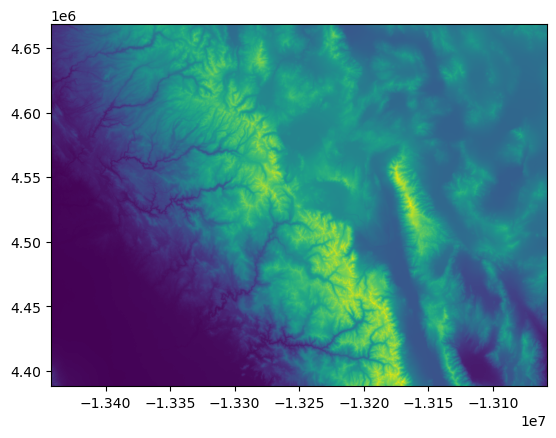

<Axes: >

In [13]:
rasterio.plot.show(src)

This function automatically handles the raster's georeferencing, ensuring that the raster is displayed in its correct geographic position.

### Plotting a Specific Band

Rasterio supports multi-band rasters (e.g., satellite imagery). To display a specific band, you can pass the band number as a tuple along with the dataset object. Here, we plot the first band:

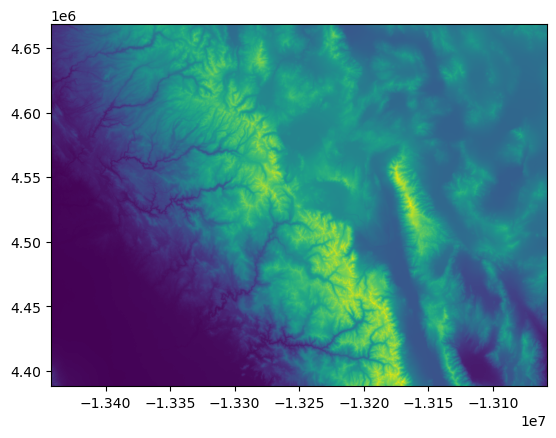

<Axes: >

In [14]:
rasterio.plot.show((src, 1))

In geospatial data, bands refer to different layers of data (e.g., red, green, blue, infrared for satellite images). The band index in `rasterio` is 1-based, so band 1 refers to the first band in the dataset.

### Customizing Plots

You can further enhance your plots with color maps and titles. Here’s an example that customizes the colormap to terrain and adds a title to the plot:

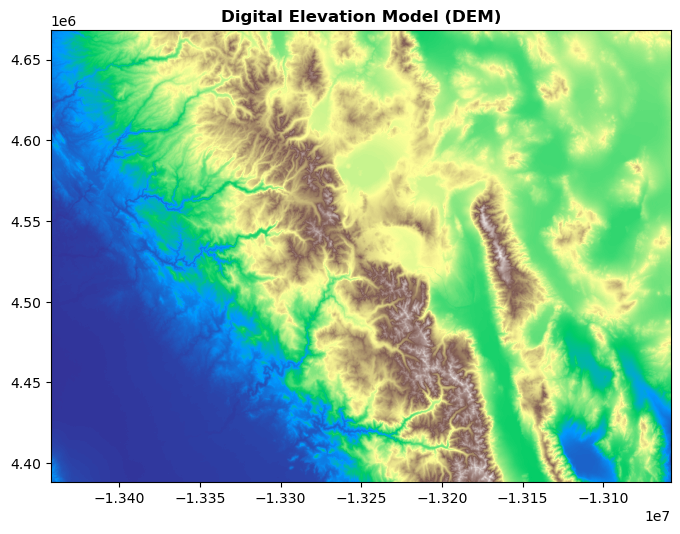

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
rasterio.plot.show(src, cmap="terrain", ax=ax, title="Digital Elevation Model (DEM)")
plt.show()

### Plotting a Vector Layer on Top of a Raster Image

In geospatial analysis, it is common to overlay vector data on top of raster images to provide additional context. Vector data often represents boundaries, roads, or other features, while raster data represents continuous fields like elevation or temperature. For instance, we might want to plot a vector boundary over a Digital Elevation Model (DEM) raster. In this example, we load a GeoJSON file containing vector data, ensure it has the same CRS as the raster, and plot it on top of the DEM.

First, let's load the vector data and reproject it to match the CRS of the raster:

In [16]:
dem_bounds = (
    "https://github.com/opengeos/datasets/releases/download/places/dem_bounds.geojson"
)
gdf = gpd.read_file(dem_bounds)
gdf = gdf.to_crs(src.crs)

The vector data is read using `geopandas.read_file()`, and then we ensure the vector data’s CRS matches the CRS of the raster using `gdf.to_crs(src.crs)`. This step is critical to ensure proper alignment between the raster and vector layers.

Next, we can plot the DEM raster and overlay the vector data:

<Axes: title={'center': 'Digital Elevation Model (DEM)'}>

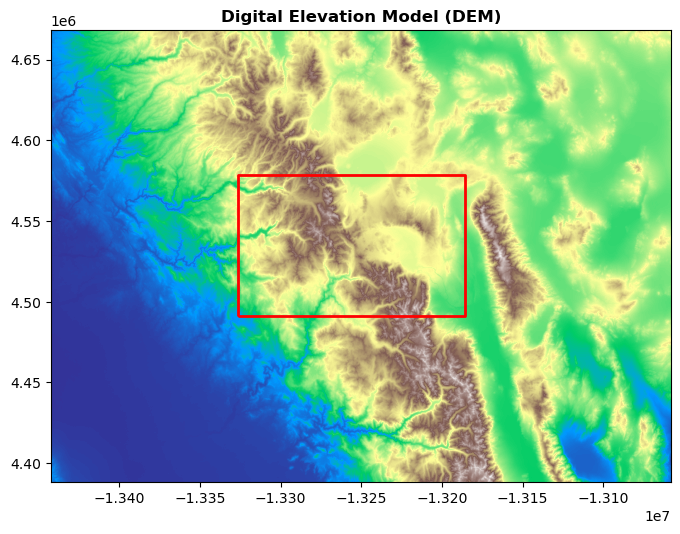

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
rasterio.plot.show(src, cmap="terrain", ax=ax, title="Digital Elevation Model (DEM)")
gdf.plot(ax=ax, edgecolor="red", facecolor="none", lw=2)

In this block, we use `rasterio.plot.show()` to plot the raster data, using the `"terrain"` colormap to visualize the elevation changes. We then overlay the vector boundary on top using `gdf.plot()`. The `edgecolor='red'` sets the boundary color to red, and `facecolor='none'` ensures the interior of the boundary remains transparent, making it easier to view the raster underneath.

### Custom Colormap and Colorbar

When visualizing raster data, colormaps help map pixel values to colors, while colorbars provide a scale reference for interpreting the pixel values. In this example, we will plot the first band of the DEM with a custom colormap (`'terrain'`) and add a colorbar to better interpret the elevation values.

Let's read the first band and plot it with a colormap:

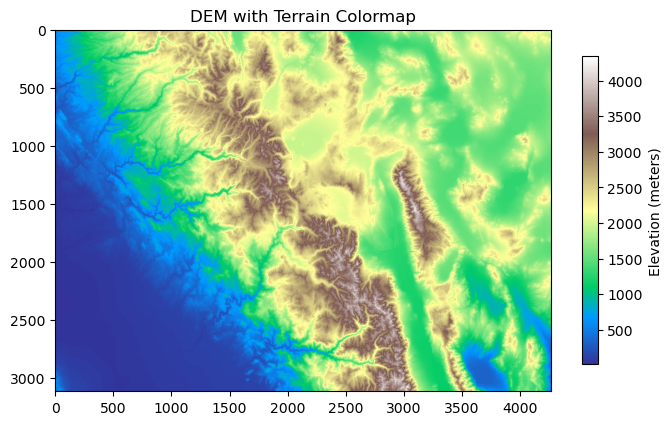

In [18]:
elev_band = src.read(1)
plt.figure(figsize=(8, 8))
plt.imshow(elev_band, cmap="terrain")
plt.colorbar(label="Elevation (meters)", shrink=0.5)
plt.title("DEM with Terrain Colormap")
plt.show()

Here, we read the first band of the raster using `src.read(1)`, which corresponds to the elevation data of the DEM. The `plt.imshow()` function displays the raster using the `'terrain'` colormap. We also add a colorbar using `plt.colorbar()` to provide a reference for interpreting the elevation values, and the `shrink=0.5` option scales the colorbar to fit the figure.

The plot shows the DEM with a color map that highlights different elevations using the `'terrain'` color scheme. The colorbar provides a clear scale to understand how the pixel values (representing elevation in meters) are distributed. The plot also has a title to provide additional context.

## Accessing and Manipulating Raster Bands

Raster datasets often consist of multiple bands, each capturing a different part of the electromagnetic spectrum. For instance, satellite images may include separate bands for red, green, blue, and near-infrared (NIR) wavelengths.

### Reading Multiple Bands

To start, let's open a multi-band raster dataset using the `rasterio` library.

In [19]:
raster_path = "https://github.com/opengeos/datasets/releases/download/raster/LC09_039035_20240708_90m.tif"
src = rasterio.open(raster_path)
print(src)

<open DatasetReader name='https://github.com/opengeos/datasets/releases/download/raster/LC09_039035_20240708_90m.tif' mode='r'>


Once the file is opened, we can inspect its metadata to learn about the dataset:

In [20]:
src.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -inf,
 'width': 2485,
 'height': 2563,
 'count': 7,
 'crs': CRS.from_epsg(32611),
 'transform': Affine(90.0, 0.0, 582390.0,
        0.0, -90.0, 4105620.0)}

This dataset contains multiple bands, each corresponding to a specific wavelength range, as described in the table below:

| Name   | Wavelength       | Description                                        |
|--------|------------------|----------------------------------------------------|
| SR_B1  | 0.435-0.451 μm   | Band 1 (ultra blue, coastal aerosol) surface reflectance |
| SR_B2  | 0.452-0.512 μm   | Band 2 (blue) surface reflectance                   |
| SR_B3  | 0.533-0.590 μm   | Band 3 (green) surface reflectance                  |
| SR_B4  | 0.636-0.673 μm   | Band 4 (red) surface reflectance                    |
| SR_B5  | 0.851-0.879 μm   | Band 5 (near infrared) surface reflectance          |
| SR_B6  | 1.566-1.651 μm   | Band 6 (shortwave infrared 1) surface reflectance   |
| SR_B7  | 2.107-2.294 μm   | Band 7 (shortwave infrared 2) surface reflectance   |

For convenience, let's define a list of human-readable band names:

In [22]:
band_names = ["Coastal Aerosol", "Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2"]

We can visualize an individual band (for example, Band 5 - NIR) using `rasterio`'s plotting functionality:

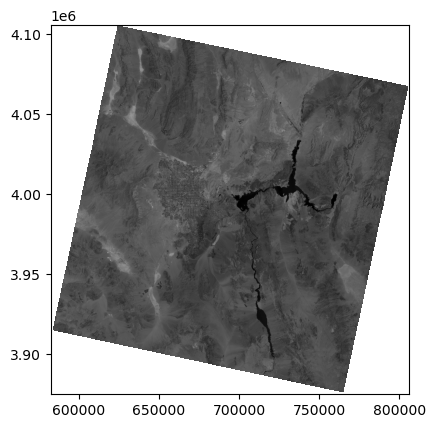

<Axes: >

In [23]:
rasterio.plot.show((src, 5), cmap="Greys_r")

### Visualizing Multiple Bands

To visualize all the bands together, we can create a multi-panel plot, displaying each band with its respective name:

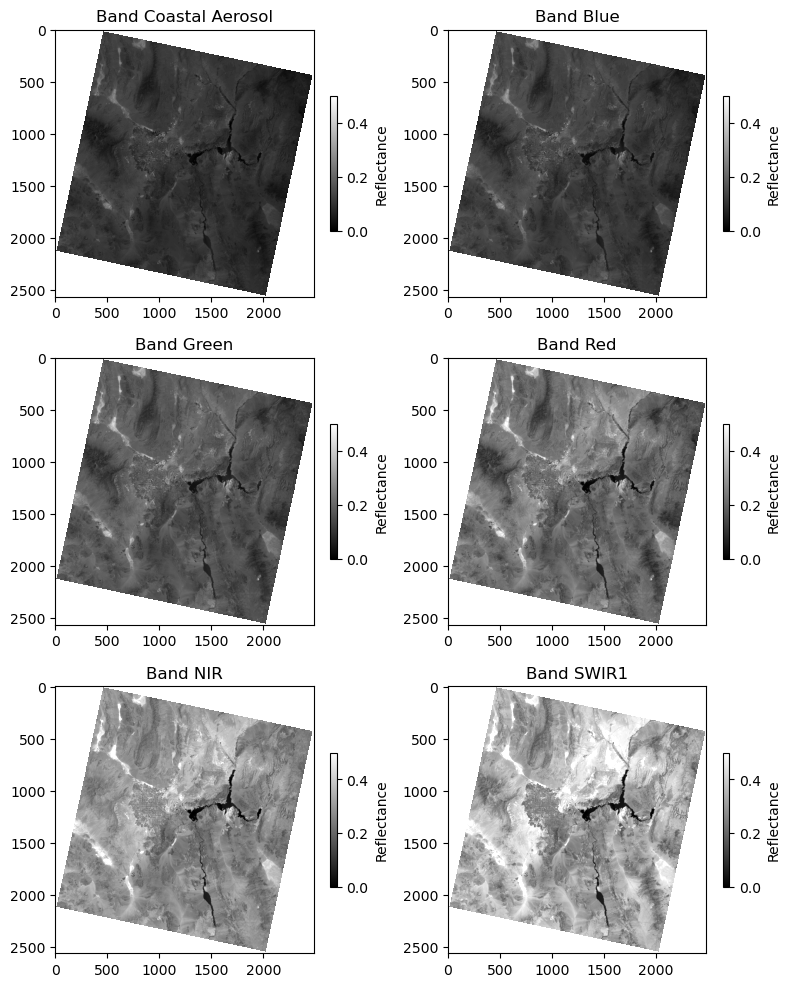

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

for band in range(1, src.count):
    data = src.read(band)
    ax = axes[band - 1]
    im = ax.imshow(data, cmap="gray", vmin=0, vmax=0.5)
    ax.set_title(f"Band {band_names[band - 1]}")
    fig.colorbar(im, ax=ax, label="Reflectance", shrink=0.5)

plt.tight_layout()
plt.show()

### Stacking and Plotting Bands

We can combine several bands into a single image by stacking them into an array. For example, we'll stack the NIR, Red, and Green bands:

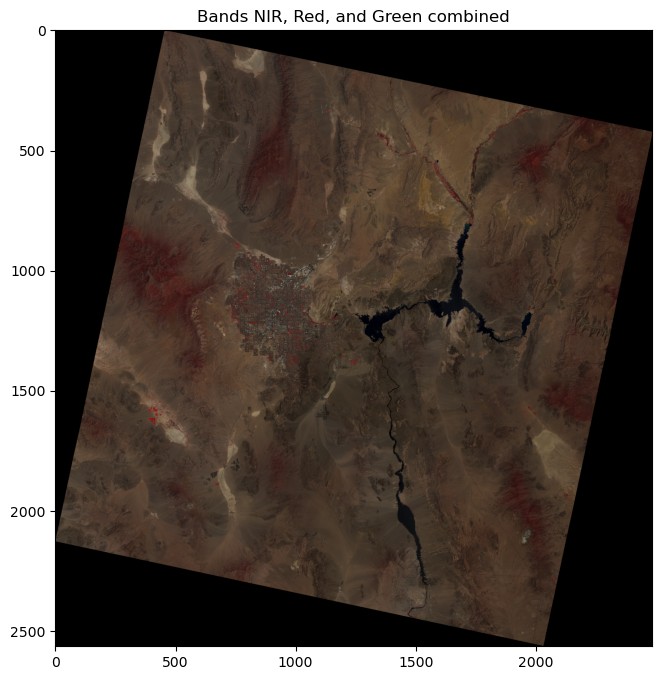

In [25]:
nir_band = src.read(5)
red_band = src.read(4)
green_band = src.read(3)

# Stack the bands into a single array
rgb = np.dstack((nir_band, red_band, green_band)).clip(0, 1)

# Plot the stacked array
plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title("Bands NIR, Red, and Green combined")
plt.show()

### Basic Band Math (NDVI Calculation)

Band math enables us to perform computations across different bands. A common application is calculating the Normalized Difference Vegetation Index (NDVI), which is an indicator of vegetation health.

NDVI is calculated as:

NDVI = (NIR - Red) / (NIR + Red)

We can compute and plot the NDVI as follows:

C:\Users\User\AppData\Local\Temp\ipykernel_13352\410884796.py:2: RuntimeWarning: invalid value encountered in subtract
  ndvi = (nir_band - red_band) / (nir_band + red_band)


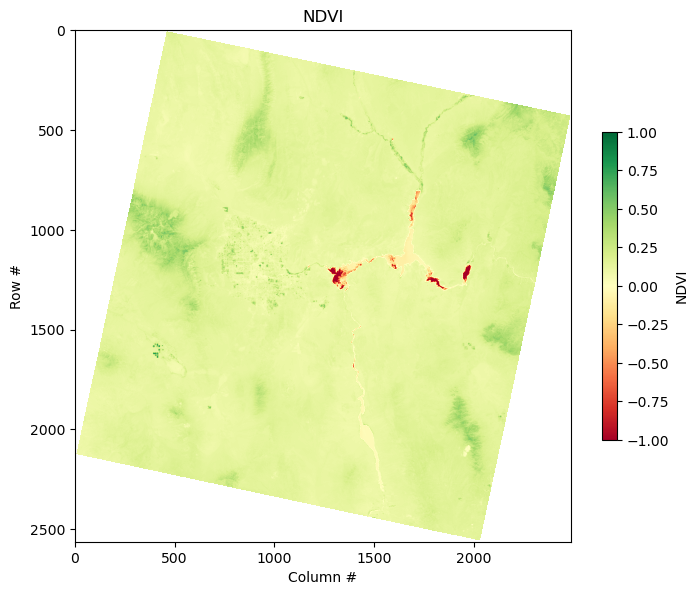

In [26]:
# NDVI Calculation: NDVI = (NIR - Red) / (NIR + Red)
ndvi = (nir_band - red_band) / (nir_band + red_band)
ndvi = ndvi.clip(-1, 1)

plt.figure(figsize=(8, 8))
plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
plt.colorbar(label="NDVI", shrink=0.5)
plt.title("NDVI")
plt.xlabel("Column #")
plt.ylabel("Row #")
plt.show()

## Writing Raster Data

After processing the raster data (e.g., computing NDVI), you may want to save the results to a new file. Using `rasterio`, we can write the data back to a GeoTIFF file.

First, we review and update the profile (metadata) for the output file:

In [27]:
with rasterio.open(raster_path) as src:
    profile = src.profile
print(profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -inf, 'width': 2485, 'height': 2563, 'count': 7, 'crs': CRS.from_epsg(32611), 'transform': Affine(90.0, 0.0, 582390.0,
       0.0, -90.0, 4105620.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'pixel'}


Then, we adjust the profile to fit the modified dataset (e.g., NDVI):

In [28]:
profile.update(dtype=rasterio.float32, count=1, compress="lzw")
print(profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -inf, 'width': 2485, 'height': 2563, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(90.0, 0.0, 582390.0,
       0.0, -90.0, 4105620.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


Finally, we write the NDVI data to a new file:

In [29]:
output_raster_path = "ndvi.tif"

with rasterio.open(output_raster_path, "w", **profile) as dst:
    dst.write(ndvi, 1)
print(f"Raster data has been written to {output_raster_path}")

Raster data has been written to ndvi.tif


## Clipping Raster Data

To extract a subset of the raster data, we can either slice the array or use geographic bounds.

First, let's open the sample raster dataset:

In [30]:
src = rasterio.open(raster_path)
data = src.read()

In [31]:
data.shape

(7, 2563, 2485)

Then, let's clip a portion of the raster data using array indices:

In [32]:
subset = data[:, 900:1400, 700:1200].clip(0, 1)
rgb_subset = np.dstack((subset[4], subset[3], subset[2]))
rgb_subset.shape

(500, 500, 3)

In [37]:
below_zero_count = (data < 0).sum()
above_one_count = (data > 1).sum()

print(f"Pixels below 0: {below_zero_count}")
print(f"Pixels above 1: {above_one_count}")

Pixels below 0: 12942599
Pixels above 1: 14


In [35]:
original_min = data[:, 900:1400, 700:1200].min()
original_max = data[:, 900:1400, 700:1200].max()
print(f"Minimum value: {original_min}")
print(f"Maximum value: {original_max}")

Minimum value: -0.1407649964094162
Maximum value: 1.2197974920272827


In [36]:
subset = data[:, 900:1400, 700:1200]
below_zero_count = (subset < 0).sum()
above_one_count = (subset > 1).sum()

print(f"Pixels below 0: {below_zero_count}")
print(f"Pixels above 1: {above_one_count}")
# Indicates number of individual band values that are below 0, not the number of pixels where at least one band is below 0

Pixels below 0: 532
Pixels above 1: 8


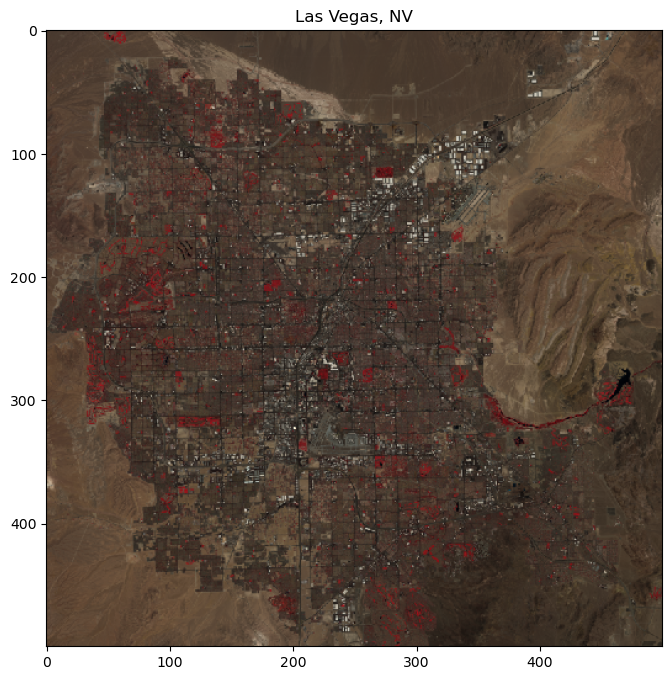

In [33]:
# Plot the stacked array
plt.figure(figsize=(8, 8))
plt.imshow(rgb_subset)
plt.title("Las Vegas, NV")
plt.show()

Alternatively, we can use a specific geographic window to clip the data:

In [34]:
from rasterio.windows import Window
from rasterio.transform import from_bounds

# Assuming subset and src are already defined
# Define the window of the subset (replace with actual window coordinates)
window = Window(col_off=700, row_off=900, width=500, height=500)

# Calculate the bounds of the window
window_bounds = rasterio.windows.bounds(window, src.transform)

# Calculate the new transform based on the window bounds
new_transform = from_bounds(*window_bounds, window.width, window.height)

After defining the window, we write the clipped data to a new file:

In [38]:
with rasterio.open(
    "las_vegas.tif",
    "w",
    driver="GTiff",
    height=subset.shape[1],
    width=subset.shape[2],
    count=subset.shape[0],
    dtype=subset.dtype,
    crs=src.crs,
    transform=new_transform,
    compress="lzw",
) as dst:
    dst.write(subset)

### Clipping with Vector Data

To clip the raster using vector data (e.g., a GeoJSON bounding box), we can use `rasterio.mask`. First, load the vector data:

In [ ]:
import fiona
import rasterio.mask

In [ ]:
geojson_path = "https://github.com/opengeos/datasets/releases/download/places/las_vegas_bounds_utm.geojson"
bounds = gpd.read_file(geojson_path)

Visualize the raster and vector data together:

In [ ]:
fig, ax = plt.subplots()
rasterio.plot.show(src, ax=ax)
bounds.plot(ax=ax, edgecolor="red", facecolor="none")

Next, apply the mask to extract only the area within the vector bounds:

In [ ]:
with fiona.open(geojson_path, "r") as f:
    shapes = [feature["geometry"] for feature in f]

In [ ]:
out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)

Finally, write the clipped raster to a new file:

In [ ]:
out_meta = src.meta
out_meta.update(
    {
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
    }
)

with rasterio.open("las_vegas_clip.tif", "w", **out_meta) as dst:
    dst.write(out_image)

## Reprojecting Raster Data

To reproject a raster from one coordinate reference system (CRS) to another, we use the `rasterio.warp` module. In this example, we reproject a raster to the WGS 84 (EPSG:3857) CRS and save the reprojected raster to a new file.

In [ ]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

raster_path = "las_vegas.tif"
dst_crs = "EPSG:3857"  # WGS 84
output_reprojected_path = "reprojected_raster.tif"

with rasterio.open(raster_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )

    profile = src.profile
    profile.update(crs=dst_crs, transform=transform, width=width, height=height)

    with rasterio.open(output_reprojected_path, "w", **profile) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,
            )
print(f"Reprojected raster saved at {output_reprojected_path}")

## Creating Raster Data from Scratch

In some cases, you might want to create raster data from scratch. In this example, we generate synthetic data representing a surface using NumPy and visualize it using both 2D and 3D plots.

In [ ]:
x = np.linspace(-4.0, 4.0, 240)
y = np.linspace(-3.0, 3.0, 180)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-2 * np.log(2) * ((X - 0.5) ** 2 + (Y - 0.5) ** 2) / 1**2)
Z2 = np.exp(-3 * np.log(2) * ((X + 0.5) ** 2 + (Y + 0.5) ** 2) / 2.5**2)
Z = 10.0 * (Z2 - Z1)

### 2D Contour Plot

We can visualize the data in a 2D contour plot.

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.contourf(X, Y, Z, cmap="RdYlBu")
plt.show()

### 3D Surface Plot with Matplotlib

For a more interactive view, we can generate a 3D surface plot using Matplotlib.

In [ ]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Plot the surface
ax.plot_surface(X, Y, Z, cmap="viridis")

# Add labels
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")
ax.set_title("3D Surface Plot")

# Show the plot
plt.show()

### 3D Surface Plot with Plotly

Alternatively, we can create a 3D surface plot with Plotly for better interactivity.

In [ ]:
import plotly.graph_objects as go

# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale="Viridis")])

# Add labels and title
fig.update_layout(
    title="3D Surface Plot",
    scene=dict(xaxis_title="X axis", yaxis_title="Y axis", zaxis_title="Z axis"),
    autosize=False,
    width=800,
    height=800,
    margin=dict(l=65, r=50, b=65, t=90),
)

# Show the plot
fig.show()

### Writing Synthetic Raster Data to a File

To save the synthetic raster data to a GeoTIFF file, we first need to define a transform using the `Affine` module, which sets the spatial resolution and origin.

In [ ]:
from rasterio.transform import Affine

res = (x[-1] - x[0]) / 240.0
transform = Affine.translation(x[0] - res / 2, y[0] - res / 2) * Affine.scale(res, res)
transform

Finally, we can save the data as a raster using `rasterio.open`.

In [ ]:
with rasterio.open(
    "new_raster.tif",
    "w",
    driver="GTiff",
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    dtype=Z.dtype,
    crs="+proj=latlong",
    transform=transform,
) as dst:
    dst.write(Z, 1)

## Exercises

**Sample datasets**

- Singlg-band image (DEM): https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif
- Multispectral image (Landsat): https://github.com/opengeos/datasets/releases/download/raster/cog.tif

**Exercise 1: Reading and Exploring Raster Data**

1. Open the single-band DEM image using `rasterio`.
2. Retrieve and print the raster metadata, including the CRS, resolution, bounds, number of bands, and data types.
3. Display the raster’s width, height, and pixel data types to understand the grid dimensions and data structure.

**Exercise 2: Visualizing and Manipulating Raster Bands**

1. Visualize the single-band DEM using a custom colormap (e.g., cmap='terrain').
2. Open the multispectral image and visualize the first band using a suitable colormap.
3. Combine multiple bands from the multispectral image (e.g., Red, Green, and Blue) and stack them to create an RGB composite image.

**Exercise 3: Raster Clipping with Array Indexing**

1. Open the multispectral image and clip a geographic subset using array indexing (specifying row and column ranges).
2. Visualize the clipped portion of the image using matplotlib to ensure the subset is correct.
3. Save the clipped raster subset to a new file named `clipped_multispectral.tif`.

**Exercise 4: Calculating NDWI (Band Math)**

1. Open the multispectral image and extract the Green and Near-Infrared (NIR) bands.
2. Compute the Normalized Difference Water Index ([NDWI](https://en.wikipedia.org/wiki/Normalized_difference_water_index)) using the formula:

    NDWI= (Green - NIR) / (Green + NIR)

3. Visualize the NDWI result using a water-friendly colormap (e.g., cmap='Blues') to highlight water bodies.
4. Save the resulting NDWI image as a new raster file named ndwi.tif.

**Exercise 5: Reprojecting Raster Data**

1. Reproject the single-band DEM raster from its original CRS to EPSG:4326 (WGS 84) using the `rasterio.warp.reproject` function.
2. Save the reprojected raster to a new GeoTIFF file named `reprojected_dem.tif`.
3. Visualize both the original and reprojected DEM datasets to compare how the reprojection affects the spatial coverage and resolution.

## Summary

Rasterio is a powerful and flexible tool for handling geospatial raster data in Python. Whether you are visualizing satellite imagery, performing raster math, or saving new datasets, it offers a convenient interface for working with raster data. The examples and exercises provided should help you gain hands-on experience with Rasterio, enabling you to work more confidently with geospatial data in various applications.